In [1]:
import ROOT
import root_numpy as rnp
import l1THistos as histos
import math
import uuid

ROOT.enableJSVis()

# some useful globals, mainly to deal with ROOT idiosyncrasies
c_idx = 0
p_idx = 0
colors = [1,2,3,4,5]
stuff = []


# define some utility functions
def newCanvas(name=None, title=None, xdiv=0, ydiv=0, form=4):
    global c_idx
    if name is None:
        name = 'c_{}'.format(c_idx)
        c_idx += 1
    if title is None:
        title = name
    # print name, title
    canvas = ROOT.TCanvas(name, title, form)
    if(xdiv*ydiv != 0):
        canvas.Divide(xdiv,ydiv)
    return canvas



def draw(plot, options=''):
    c = newCanvas()
    c.cd()
    plot.Draw(options)
    c.Draw()
    return


def getLegend(x1=0.7, y1=0.71, x2=0.95, y2=0.85):
    global stuff
    legend = ROOT.TLegend(x1, y1, x2, y2)
    stuff.append(legend)
    legend.SetFillColor(0)
    legend.SetFillStyle(0)
    legend.SetBorderSize(0)
    #legend.SetTextSize(30)
    return legend
    

def drawAndProfileX(plot2d, miny=None, maxy=None, do_profile=True, options=''):
    global p_idx
    ROOT.gPad.SetGrid(1,1)
    ROOT.gStyle.SetGridColor(15)
    if miny and maxy:
        h2.GetYaxis().SetRangeUser(miny,maxy)
    c = newCanvas()
    c.SetGrid(1,1)
    c.cd()
    plot2d.Draw(options)
    if do_profile:
        profname = plot2d.GetName()+'_prof_'+str(p_idx)
        p_idx+=1
        firstbin = 1
        lastbin = -1
        prof = plot2d.ProfileX(profname, firstbin, lastbin, 's');
        prof.SetMarkerColor(2)
        prof.SetLineColor(2)
        prof.Draw('same')
    c.Draw()


class Sample():
    def __init__(cls, name, pu_tag):
        cls.name = name
        cls.pu_tag = pu_tag
        cls.histo_filename = 'histos_{}_{}.root'.format(cls.name, cls.pu_tag)
        cls.histo_file = ROOT.TFile(cls.histo_filename)

        
def drawSame(histograms, labels, options='', norm=False, logy=False):
    global colors
    c = newCanvas()
    c.cd()
    leg = getLegend()
    if norm:
        for hist in histograms:
            hist.Scale(1./hist.Integral())
    
    max_value = max([hist.GetMaximum() for hist in histograms]) 
    min_value = min([hist.GetMinimum() for hist in histograms])
    for hidx in range(0, len(histograms)):
        histograms[hidx].SetLineColor(colors[hidx])
        histograms[hidx].Draw('same'+','+options)
        leg.AddEntry(histograms[hidx], labels[hidx], 'l')

    histograms[0].GetYaxis().SetRangeUser(min_value, max_value*1.1)
    leg.Draw()
    c.Draw()
    if logy:
        c.SetLogy()

    
def drawProfileX(histograms, labels, options=''):
    profiles = [hist.ProfileX() for hist in histograms]
    drawSame(profiles, labels, options)
    

def drawSeveral(histograms, labels, options='', do_profile=False):
    ydiv = int(math.ceil(float(len(histograms))/2))
    for hidx in range(0, len(histograms)):
        if do_profile:
            drawAndProfileX(histograms[hidx], options=options, do_profile=do_profile)
        else:
            draw(histograms[hidx], options=options)

def drawProfileRatio(prof1, prof2, ymin=None, ymax=None):
    hist1 = prof1.ProjectionX(uuid.uuid4().hex[:6])
    hist2 = prof2.ProjectionX(uuid.uuid4().hex[:6])
    hist1.Divide(hist2)
    draw(hist1)
    if ymin is not None and ymax is not None:
        hist1.GetYaxis().SetRangeUser(ymin, ymax)

    

Welcome to JupyROOT 6.10/08


In [2]:

samplePU50 = Sample('NuGun', 'PU50')
samplePU100 = Sample('NuGun', 'PU100')
samplePU140 = Sample('NuGun', 'PU140')
samplePU200 = Sample('NuGun', 'PU200')


samplePU50.histo_file.ls()

samples = [samplePU50, samplePU100, samplePU140, samplePU200]
pu_labels = [sample.pu_tag for sample in samples]



TFile**		histos_NuGun_PU50.root	
 TFile*		histos_NuGun_PU50.root	
  KEY: TH1F	h_genAll_energy;1	Gen Part Energy (GeV)
  KEY: TH1F	h_genAll_pt;1	Gen Part Pt (GeV)
  KEY: TH1F	h_hgcDigisAll_layer;1	Digi layer #
  KEY: TH1F	h_hgcDigisAll_energy;1	Digi sim-energy (GeV)
  KEY: TH1F	h_tcAll_absz;1	TC z(cm)
  KEY: TH1F	h_tcAll_energy;1	TC energy (GeV)
  KEY: TProfile2D	h_tcAll_energyPetaVphi;1	Energy profile (GeV) vs Eta and Phi
  KEY: TH2F	h_tcAll_energyVeta;1	Energy (GeV) vs Eta
  KEY: TH2F	h_tcAll_energyVetaL11t20;1	Energy (GeV) vs Eta (layers 11 to 20)
  KEY: TH2F	h_tcAll_energyVetaL1t5;1	Energy (GeV) vs Eta (layers 1 to 5)
  KEY: TH2F	h_tcAll_energyVetaL21t60;1	Energy (GeV) vs Eta (layers 21 to 60)
  KEY: TH2F	h_tcAll_energyVetaL6t10;1	Energy (GeV) vs Eta (layers 6 to 10)
  KEY: TProfile	h_tcAll_layer;1	TC layer #
  KEY: TH2F	h_tcAll_layerVenergy;1	Energy (GeV) vs Layer #
  KEY: TH1F	h_tcAll_subdet;1	TC subdet #
  KEY: TH1F	h_tcAll_wafertype;1	Wafer type
  KEY: TH1F	h_clAll_energy;1	Clus

# NuGun samples with different PU

## Trigger Cell level plots

In [3]:


htc_energies = [histos.TCHistos('h_tcAll', sample.histo_file).h_energy for sample in samples]

drawSame(htc_energies, pu_labels,'hist')

htc_energies_scaled = [histos.TCHistos('h_tcAll', sample.histo_file).h_energy.Clone() for sample in samples]

drawSame(htc_energies_scaled, pu_labels,'hist',norm=True, logy=True)

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


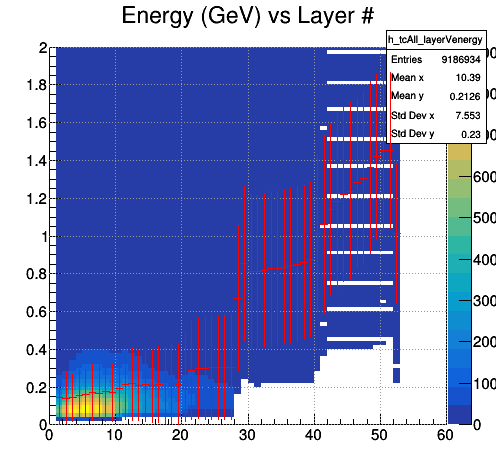

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


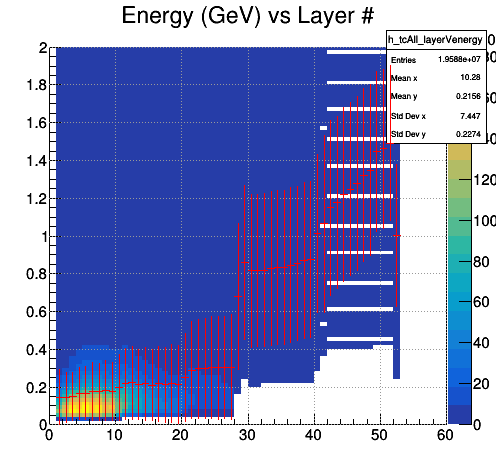

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


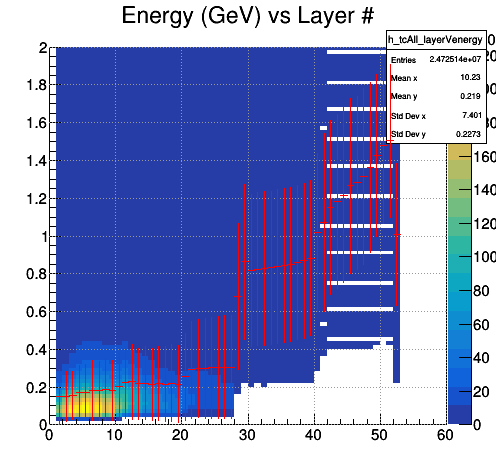

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


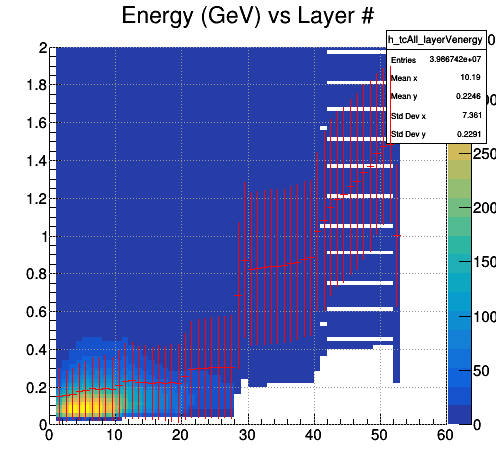

In [4]:

htc_layerVenergy = [histos.TCHistos('h_tcAll', sample.histo_file).h_layerVenergy for sample in samples]

drawSeveral(htc_layerVenergy, pu_labels,'COLZ',do_profile=True)



In [5]:
# we project the distribution on the single layer to assess the RMS
draw(htc_layerVenergy[3].ProjectionY(uuid.uuid4().hex[:6], 5, 5))


The plot below shows the average TC energy per layer # (integrated over all eta) for different PU.

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


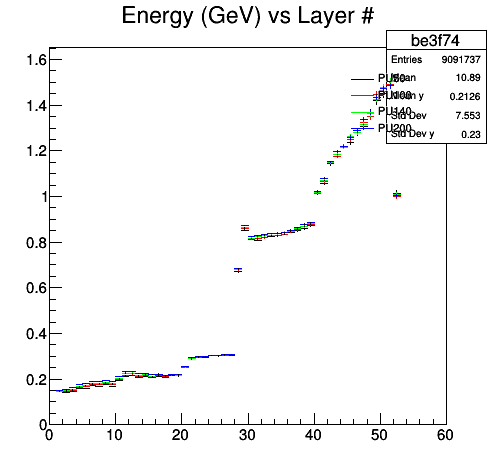

In [6]:


htc_profLayerVenergy = [histos.TCHistos('h_tcAll', sample.histo_file).h_layerVenergy.ProfileX(uuid.uuid4().hex[:6]) for sample in samples]
drawSame(htc_profLayerVenergy, pu_labels)

line = ROOT.TLine(0,1,60,1)
line.SetLineColor(2)
line.SetLineStyle(2)

#PU200/PU100
drawProfileRatio(htc_profLayerVenergy[3], htc_profLayerVenergy[2], ymin=0.8, ymax=1.2)
line.Draw('same')

#PU100/PU500
drawProfileRatio(htc_profLayerVenergy[1], htc_profLayerVenergy[0], ymin=0.8, ymax=1.2)
line.Draw('same')


The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


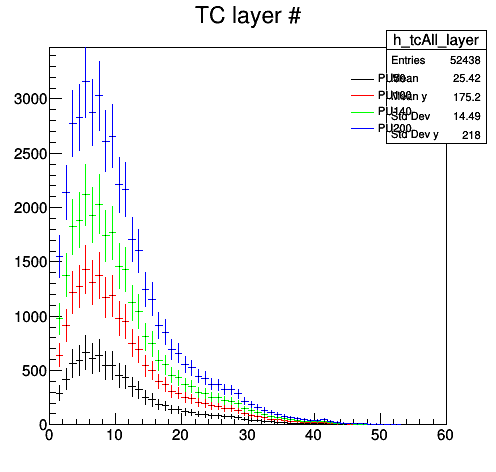

In [7]:
htc_layer = [histos.TCHistos('h_tcAll', sample.histo_file).h_layer for sample in samples]
drawSame(htc_layer, pu_labels)

In [8]:
# ration PU200 PU100
drawProfileRatio(htc_layer[3], htc_layer[1], ymin=0, ymax=4)
line2 = ROOT.TLine(0,2,60,2)
line2.SetLineColor(2)
line2.SetLineStyle(2)
line2.Draw('same')

In [9]:
# ration PU100 PU50
drawProfileRatio(htc_layer[1], htc_layer[0], ymin=0, ymax=4)
line2.Draw('same')

The # of TC per layer varies ~linearly with the PU, confirming that, apart from high-eta regions, the TC can "resolve" the PU.
The behavior vs eta is addressed in the following plots.


The canvas contains an object of a type jsROOT cannot currently handle (TProfile2D). Falling back to a static png.


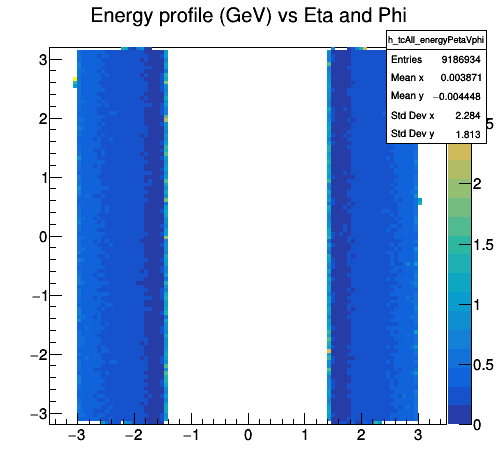

The canvas contains an object of a type jsROOT cannot currently handle (TProfile2D). Falling back to a static png.


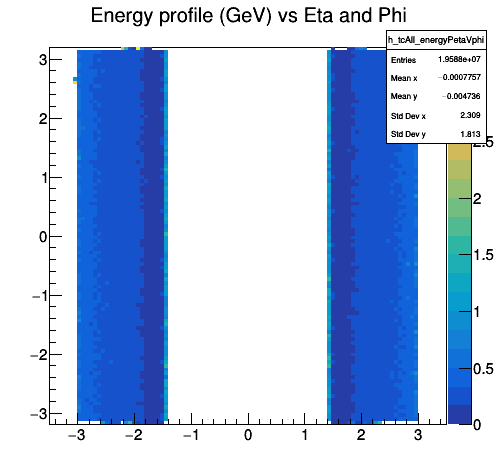

The canvas contains an object of a type jsROOT cannot currently handle (TProfile2D). Falling back to a static png.


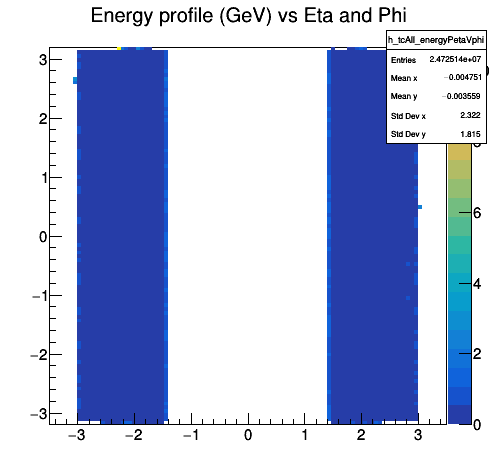

The canvas contains an object of a type jsROOT cannot currently handle (TProfile2D). Falling back to a static png.


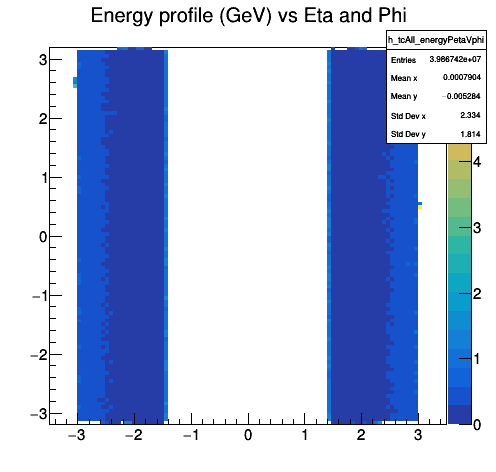

In [10]:


htcAll_energyPetaVphi = [histos.TCHistos('h_tcAll', sample.histo_file).h_energyPetaVphi for sample in samples]
drawSeveral(htcAll_energyPetaVphi, pu_labels,'COLZ',do_profile=False)


The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


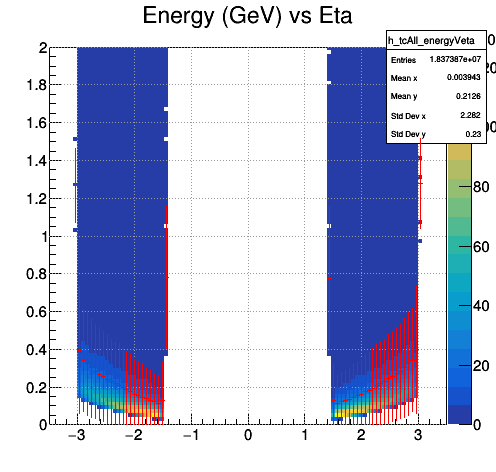

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


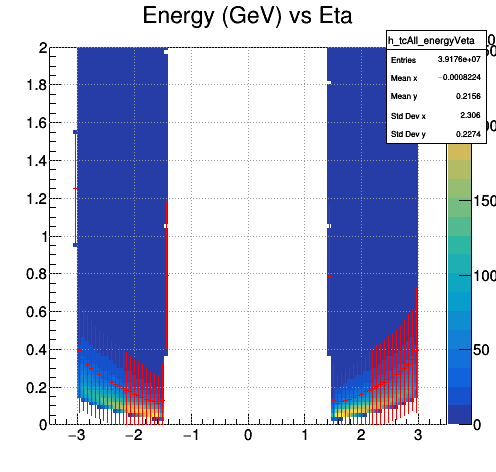

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


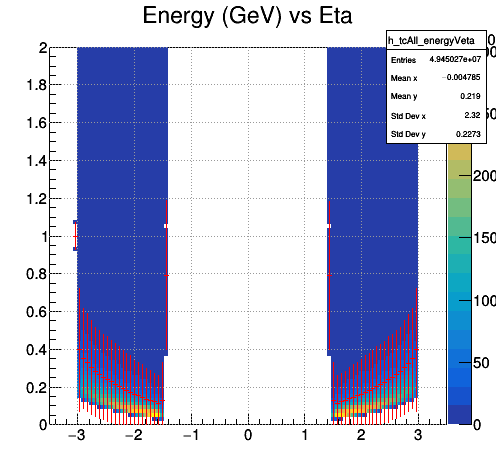

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


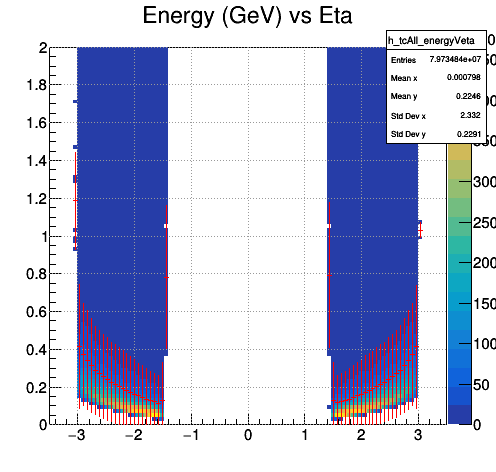

In [11]:
htcAll_energyVeta = [histos.TCHistos('h_tcAll', sample.histo_file).h_energyVeta for sample in samples]

drawSeveral(htcAll_energyVeta, pu_labels,'COLZ',do_profile=True)

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


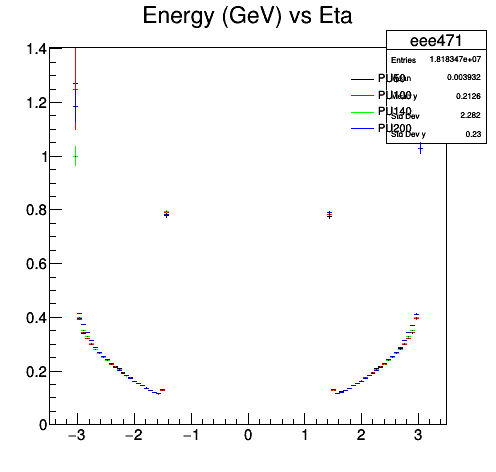

In [12]:
htcAll_profEnergyVeta = [histos.TCHistos('h_tcAll', sample.histo_file).h_energyVeta.ProfileX(uuid.uuid4().hex[:6]) for sample in samples]
drawSame(htcAll_profEnergyVeta, pu_labels)

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


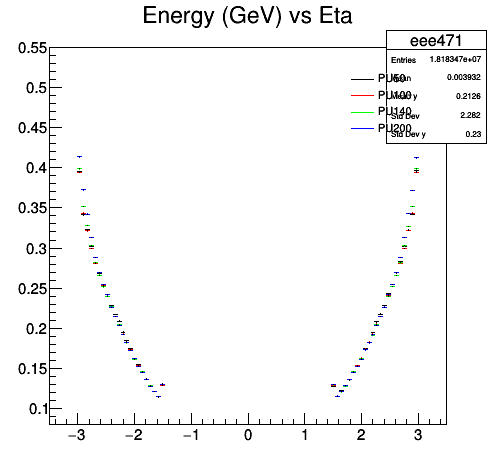

In [13]:
for hist in htcAll_profEnergyVeta:
    hist.GetYaxis().SetRangeUser(0.08,0.5)
drawSame(htcAll_profEnergyVeta, pu_labels)

line = ROOT.TLine(-4,1,+4,1)
line.SetLineColor(2)
line.SetLineStyle(2)
#PU100/PU50
drawProfileRatio(htcAll_profEnergyVeta[1], htcAll_profEnergyVeta[0], ymin=0.8, ymax=1.2)
line.Draw('same')


In [14]:
#PU200/PU100
drawProfileRatio(htcAll_profEnergyVeta[3], htcAll_profEnergyVeta[2], ymin=0.8, ymax=1.2)
line.Draw('same')

In [15]:
htcAll_profEnergyVetaL1t5 = [histos.TCHistos('h_tcAll', sample.histo_file).h_energyVetaL1t5.ProfileX(uuid.uuid4().hex[:6]) for sample in samples]
htcAll_profEnergyVetaL6t10 = [histos.TCHistos('h_tcAll', sample.histo_file).h_energyVetaL6t10.ProfileX(uuid.uuid4().hex[:6]) for sample in samples]
htcAll_profEnergyVetaL11t20 = [histos.TCHistos('h_tcAll', sample.histo_file).h_energyVetaL11t20.ProfileX(uuid.uuid4().hex[:6]) for sample in samples]
htcAll_profEnergyVetaL21t60 = [histos.TCHistos('h_tcAll', sample.histo_file).h_energyVetaL21t60.ProfileX(uuid.uuid4().hex[:6]) for sample in samples]

#PU200/PU100
drawProfileRatio(htcAll_profEnergyVetaL1t5[3], htcAll_profEnergyVetaL1t5[2], ymin=0.8, ymax=1.2)
line.Draw('same')
drawProfileRatio(htcAll_profEnergyVetaL6t10[3], htcAll_profEnergyVetaL6t10[2], ymin=0.8, ymax=1.2)
line.Draw('same')
drawProfileRatio(htcAll_profEnergyVetaL11t20[3], htcAll_profEnergyVetaL11t20[2], ymin=0.8, ymax=1.2)
line.Draw('same')
drawProfileRatio(htcAll_profEnergyVetaL21t60[3], htcAll_profEnergyVetaL21t60[2], ymin=0.8, ymax=1.2)
line.Draw('same')

## 2D cluster level plots

In [16]:
hclAll_histos = [histos.ClusterHistos('h_clAll', sample.histo_file) for sample in samples]

hclAll_energies = [histo.h_energy for histo in hclAll_histos]
drawSame(hclAll_energies, pu_labels,'hist', logy=True)


hclAll_energies_scaled = [histo.h_energy.Clone() for histo in hclAll_histos]

drawSame(hclAll_energies_scaled, pu_labels,'hist',norm=True, logy=True)



In [17]:
hclAll_layers = [histo.h_layer for histo in hclAll_histos]
drawSame(hclAll_layers, pu_labels,'hist', logy=True)


In [18]:
hclAll_ncells = [histo.h_ncells for histo in hclAll_histos]
drawSame(hclAll_ncells, pu_labels,'hist', logy=True)


The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


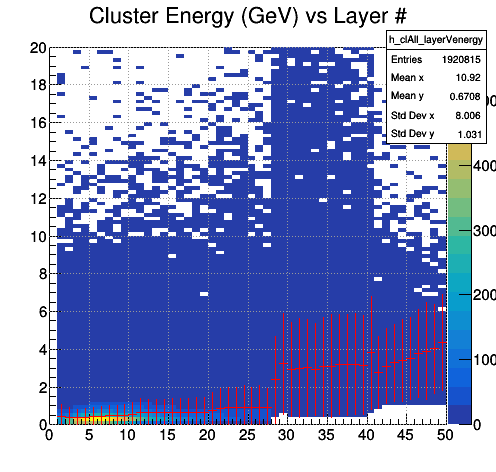

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


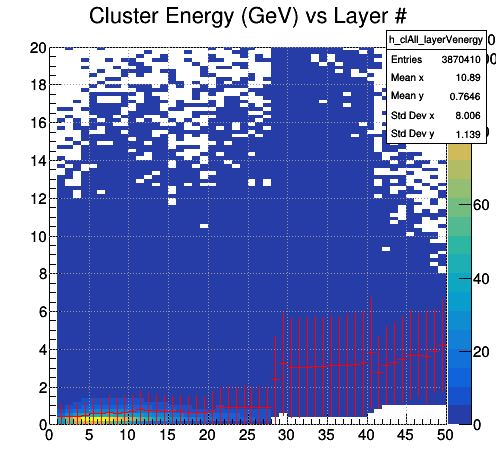

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


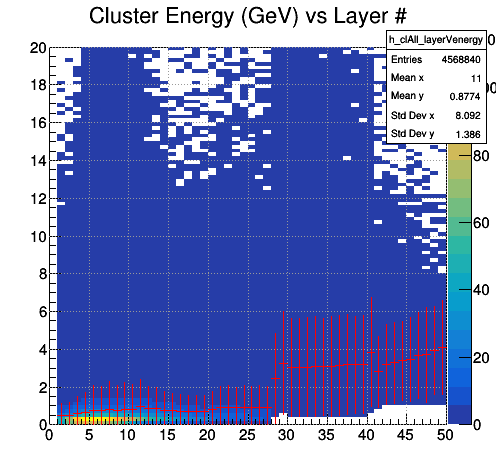

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


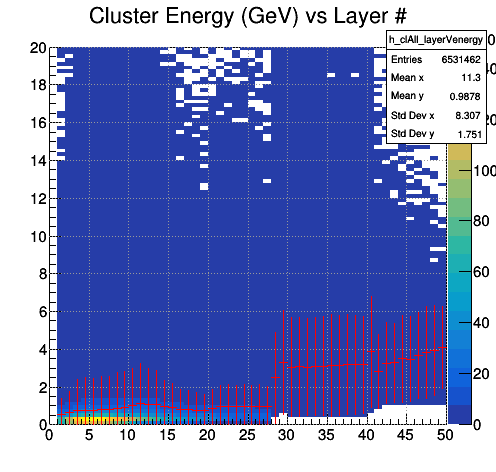

In [19]:
hclAll_layerVenergy = [histo.h_layerVenergy for histo in hclAll_histos]
drawSeveral(hclAll_layerVenergy, pu_labels,'COLZ',do_profile=True)

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


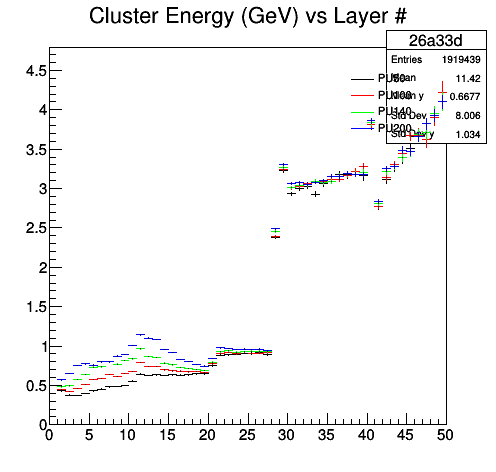

In [20]:
hclAll_profLayerVenergy = [histo.h_layerVenergy.ProfileX(uuid.uuid4().hex[:6]) for histo in hclAll_histos]
drawSame(hclAll_profLayerVenergy, pu_labels)


The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


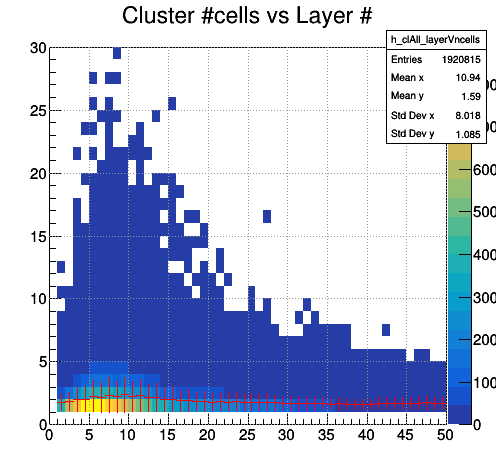

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


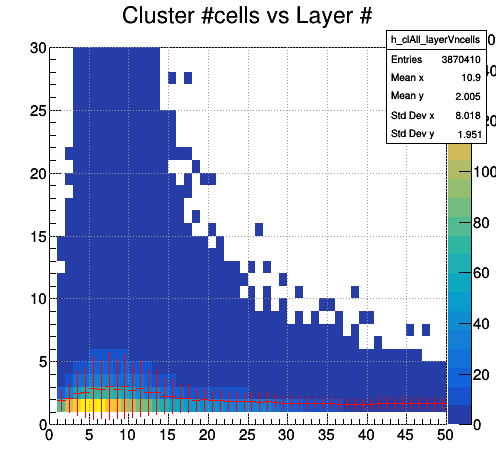

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


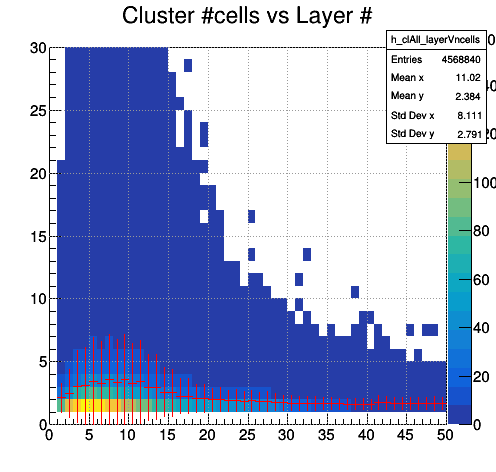

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


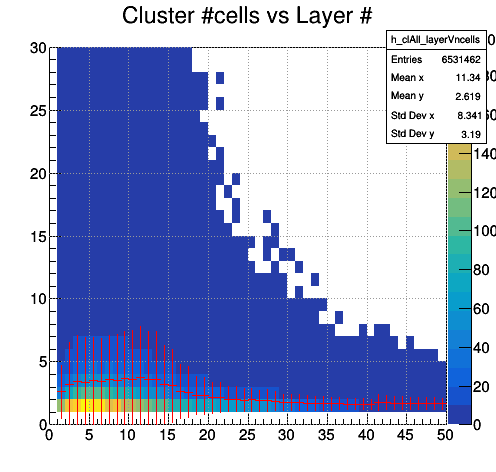

In [21]:
hclAll_layerVncells = [histo.h_layerVncells for histo in hclAll_histos]
drawSeveral(hclAll_layerVncells, pu_labels,'COLZ',do_profile=True)

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


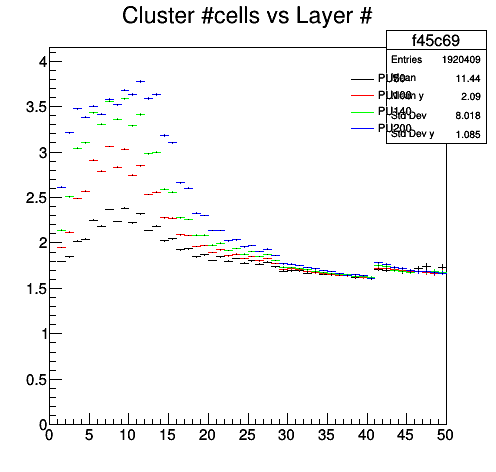

In [22]:
hclAll_profLayerVncells = [histo.h_layerVncells.ProfileX(uuid.uuid4().hex[:6]) for histo in hclAll_histos]
drawSame(hclAll_profLayerVncells, pu_labels)

In [43]:
#We plot the average energy per TC in a cluster

#PU 50 nugun
drawProfileRatio(hclAll_profLayerVenergy[0], hclAll_profLayerVncells[0], ymin=None, ymax=None)


In [44]:
# we do the same for the PU200 nu gun
drawProfileRatio(hclAll_profLayerVenergy[3], hclAll_profLayerVncells[3], ymin=None, ymax=None)


# Electron resolution studies

In [23]:



sampleElePU0 = Sample('EleE50', 'PU0')
sampleElePU50 = Sample('EleE50', 'PU50')
sampleElePU100 = Sample('EleE50', 'PU100')
sampleElePU200 = Sample('EleE50', 'PU200')

eleSamples = [sampleElePU0, sampleElePU50, sampleElePU100, sampleElePU200]
elePu_labels = [sample.pu_tag for sample in eleSamples]

In [24]:
hcl3DMatch_histos = [histos.Cluster3DHistos('h_cl3dMatch', sample.histo_file) for sample in eleSamples]
hclMatch_histos = [histos.ClusterHistos('h_clMatch', sample.histo_file) for sample in eleSamples]
htcMatch_histos = [histos.TCHistos('h_tcMatch', sample.histo_file) for sample in eleSamples]

helereso_histos = [histos.ResoHistos('h_EleReso', sample.histo_file) for sample in eleSamples]

Warning in <TFile::Append>: Replacing existing TH1: h_EleReso_ptRes (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_EleReso_energyRes (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_EleReso_ptResVeta (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_EleReso_energyResVeta (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_EleReso_ptRes (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_EleReso_energyRes (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_EleReso_ptResVeta (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_EleReso_energyResVeta (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_EleReso_ptRes (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_EleReso_energyRes (Potential memory leak).
Warning in <TFile::Append>: Replac

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


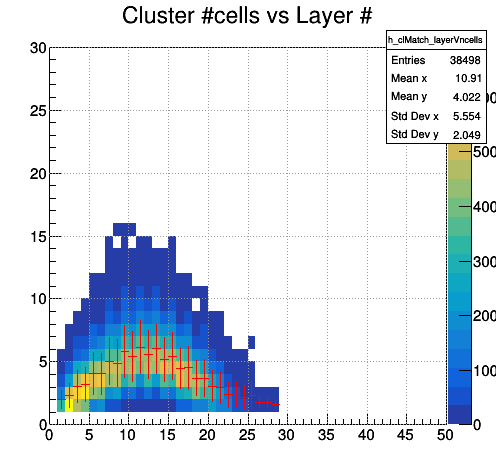

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


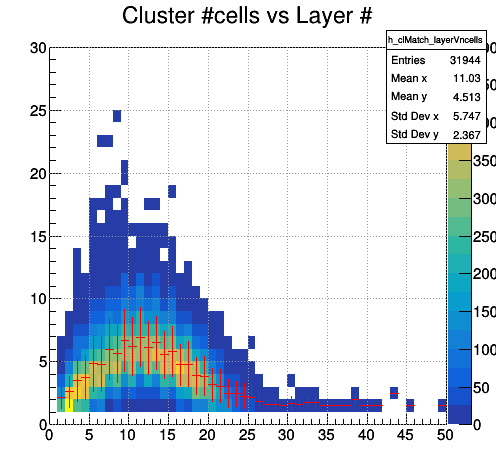

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


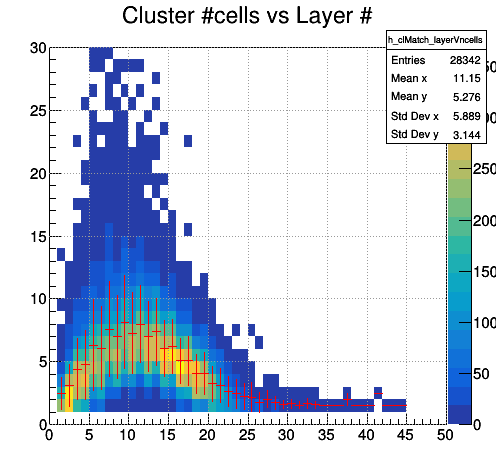

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


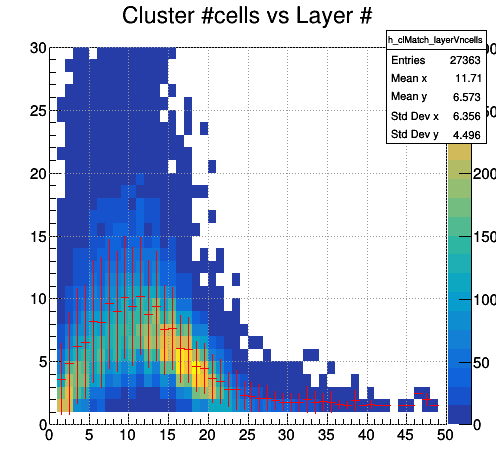

In [36]:
hclMatch_layerVncells = [histo.h_layerVncells for histo in hclMatch_histos]
drawSeveral(hclMatch_layerVncells, elePu_labels,'COLZ',do_profile=True)


The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


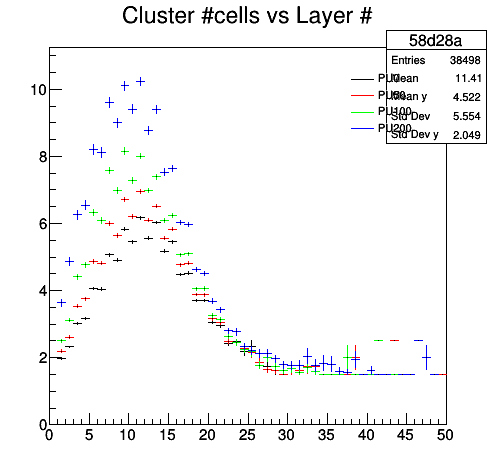

In [37]:
hclMatch_profLayerVncells = [histo.h_layerVncells.ProfileX(uuid.uuid4().hex[:6]) for histo in hclMatch_histos]
drawSame(hclMatch_profLayerVncells, elePu_labels)

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


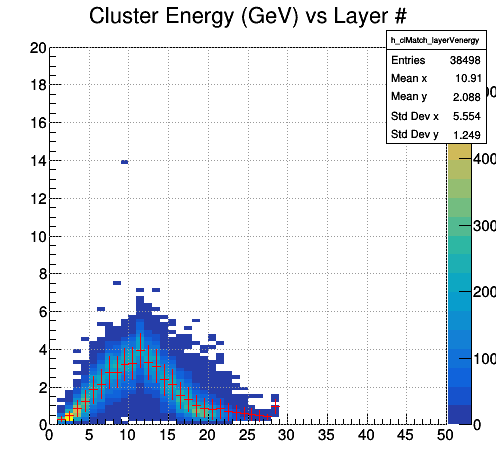

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


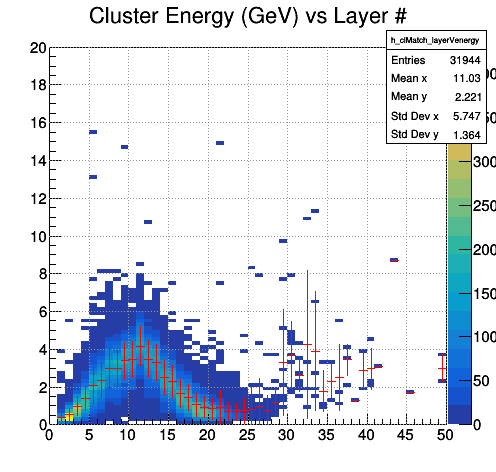

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


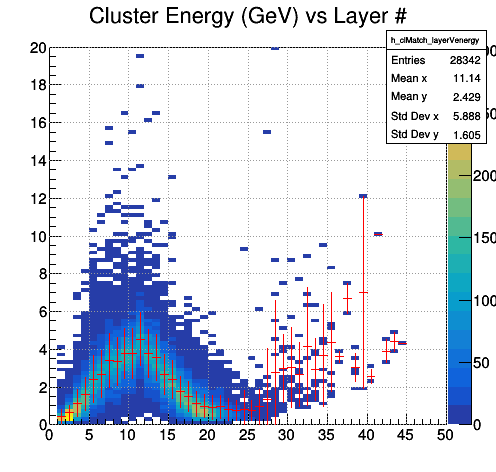

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


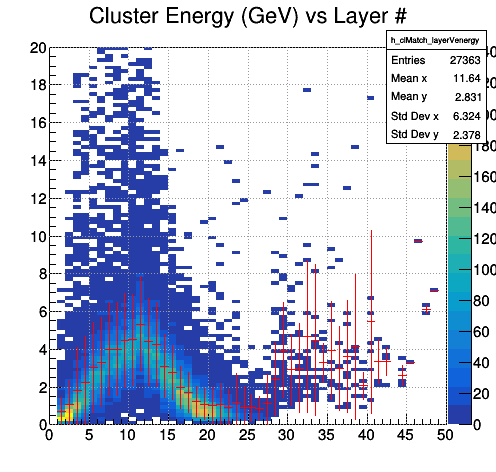

In [46]:
hclMatch_layerVenergy = [histo.h_layerVenergy for histo in hclMatch_histos]
drawSeveral(hclMatch_layerVenergy, elePu_labels,'COLZ',do_profile=True)

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


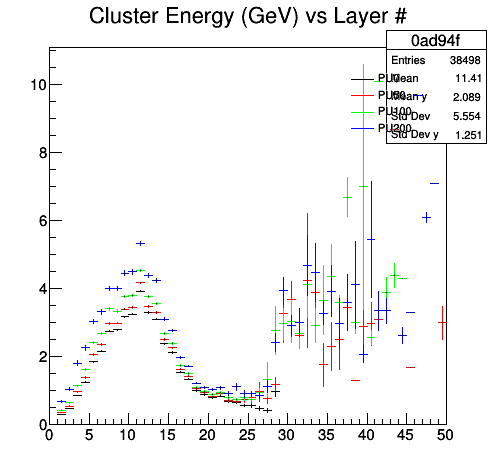

In [47]:
hclMatch_profLayerVenergy = [histo.h_layerVenergy.ProfileX(uuid.uuid4().hex[:6]) for histo in hclMatch_histos]
drawSame(hclMatch_profLayerVenergy, elePu_labels)

In [48]:
#PU 0 ele 50GeV
drawProfileRatio(hclMatch_profLayerVenergy[0], hclMatch_profLayerVncells[0], ymin=None, ymax=None)


In [49]:
#PU 200 ele 50GeV
drawProfileRatio(hclMatch_profLayerVenergy[3], hclMatch_profLayerVncells[3], ymin=None, ymax=None)


Number of 2D clusters in the matched 3D cluster

In [38]:
hcl3DMatch_nclu = [hist.h_nclu for hist in hcl3DMatch_histos]
drawSame(hcl3DMatch_nclu, elePu_labels)

In [25]:
hcl3DMatch_energy = [hist.h_energy for hist in hcl3DMatch_histos]
drawSame(hcl3DMatch_energy, elePu_labels)

In [26]:
hcl3DMatch_nclu = [hist.h_nclu for hist in hcl3DMatch_histos]
drawSame(hcl3DMatch_nclu, elePu_labels)

In [27]:
hclMatch_ncells = [hist.h_ncells for hist in hclMatch_histos]
drawSame(hclMatch_ncells, elePu_labels)

In [28]:
htcMatch_energy = [hist.h_energy for hist in htcMatch_histos]
drawSame(htcMatch_energy, elePu_labels, options='hist')

htcMatch_energy_norm = [hist.h_energy.Clone() for hist in htcMatch_histos]
drawSame(htcMatch_energy_norm, elePu_labels,norm=True, options='hist')


In [29]:
# let's compare E distribution with and without signal
tc_energies_comp = [htcMatch_energy_norm[3], htc_energies_scaled[3]]
drawSame(tc_energies_comp, ['w 50GeV signal PU200', 'nu-gun PU200'])

In [39]:
hclMatch_energy = [hist.h_energy for hist in hclMatch_histos]
drawSame(hclMatch_energy, elePu_labels, options='hist')

hclMatch_energy_norm = [hist.h_energy.Clone() for hist in hclMatch_histos]
drawSame(hclMatch_energy_norm, elePu_labels,norm=True, options='hist')






In [41]:
cl2d_energy_comp = [hclMatch_energy_norm[3], hclAll_energies_scaled[3]]
drawSame(cl2d_energy_comp, ['w 50GeV signal PU200', 'nu-gun PU200'])

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


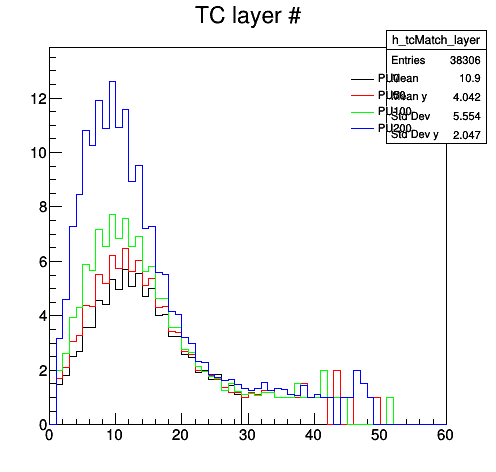

In [30]:
htcMatch_layer = [hist.h_layer for hist in htcMatch_histos]
drawSame(htcMatch_layer, elePu_labels, options='hist')


The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


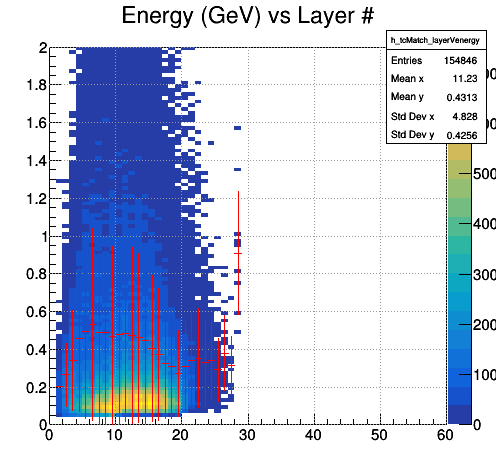

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


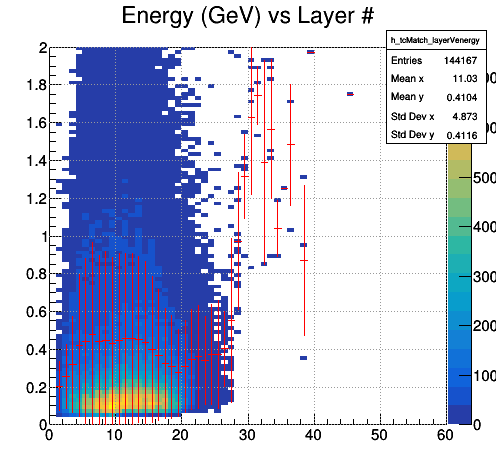

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


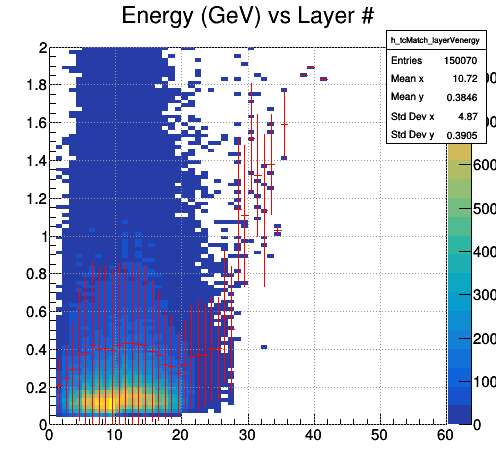

The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


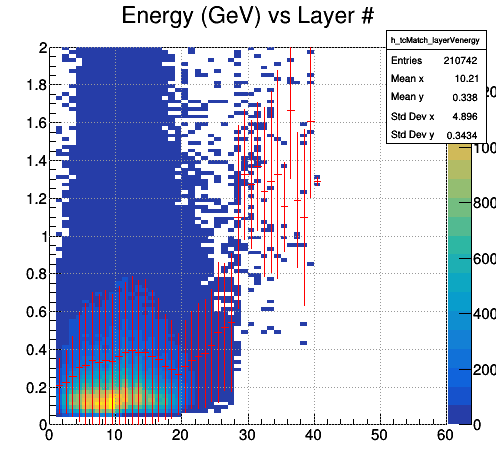

In [31]:
htcMatch_energyVlayer = [hist.h_layerVenergy for hist in htcMatch_histos]
drawSeveral(htcMatch_energyVlayer, elePu_labels, 'COLZ',do_profile=True)


The canvas contains an object of a type jsROOT cannot currently handle (TProfile). Falling back to a static png.


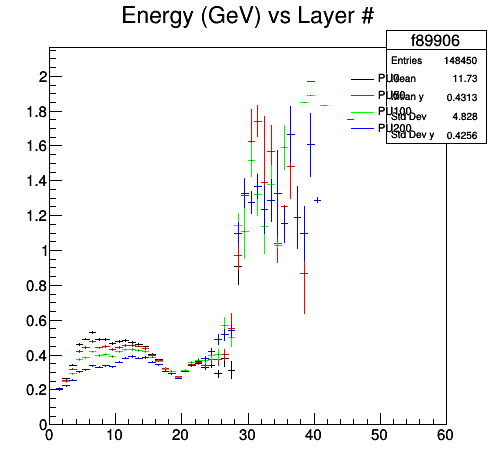

In [32]:
htcMatch_profEnergyVlayer = [hist.ProfileX(uuid.uuid4().hex[:6]) for hist in htcMatch_energyVlayer]
drawSame(htcMatch_profEnergyVlayer, elePu_labels)

In [33]:
helereso_ptRes = [hist.h_ptRes for hist in helereso_histos]
drawSame(helereso_ptRes, elePu_labels)

In [34]:
helereso_energyRes = [hist.h_energyRes for hist in helereso_histos]
drawSame(helereso_energyRes, elePu_labels,options='hist')